In [93]:
!python -m pip install feature-engine xgboost seaborn prophet scikit-optimize

In [94]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
#use Mean Absolute Error MAE as loss

# Store Data as Dataframes

In [95]:
#train data
#id then 11 features
X= pd.read_csv("train_examples.csv", index_col='id')

#train labels (duration)
y= pd.read_csv("train_labels.csv", index_col='id')

X_test= pd.read_csv("test_examples.csv", index_col='id')

# Check for Correlated Features
###  Note:
Try and ignore feature_0 for now, see if can find relationship in data without having to transform datetime strings

<Axes: >

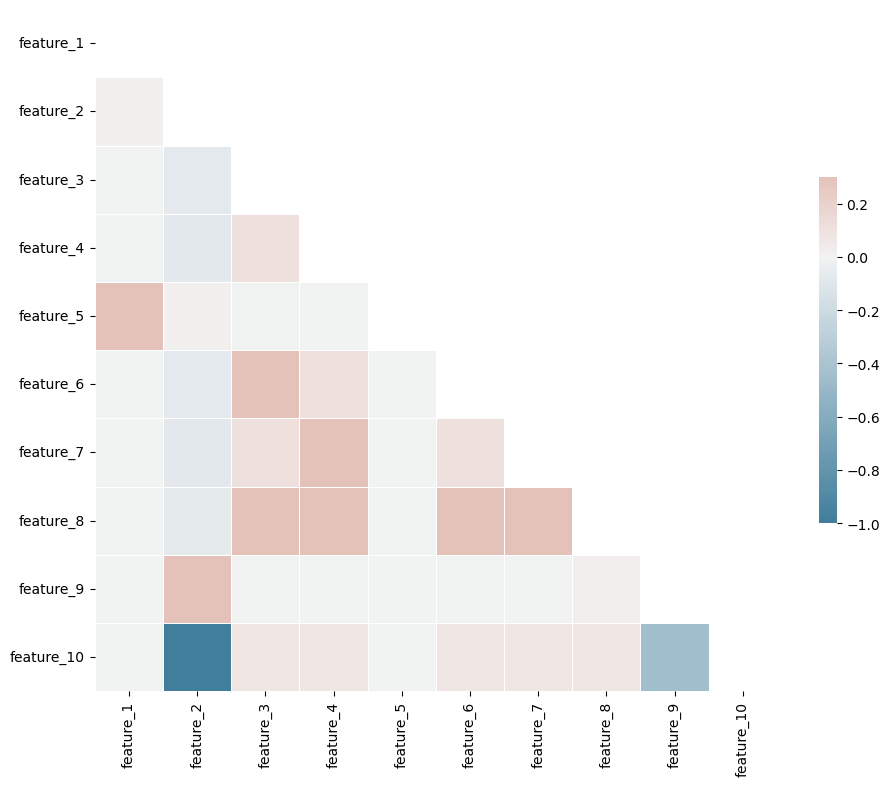

In [96]:
#feature correlations
import seaborn as sns
import matplotlib.pyplot as plt
feat_X=X.drop(['feature_0'], axis=1)
corr= feat_X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [97]:
corr_masked = corr.mask(mask)
corr_masked.fillna(0)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
feature_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
feature_2,0.008354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
feature_3,-0.008419,-0.077515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
feature_4,-0.005660,-0.082528,0.113338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
feature_5,1.000000,0.008354,-0.008419,-0.005660,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
feature_6,-0.008419,-0.077515,1.000000,0.113338,-0.008419,0.000000,0.000000,0.000000,0.000000,0.0
feature_7,-0.005660,-0.082528,0.113338,1.000000,-0.005660,0.113338,0.000000,0.000000,0.000000,0.0
feature_8,-0.009083,-0.068281,0.728470,0.762113,-0.009083,0.728470,0.762113,0.000000,0.000000,0.0
feature_9,-0.001802,0.450232,-0.001497,-0.000298,-0.001802,-0.001497,-0.000298,0.016557,0.000000,0.0
feature_10,-0.008354,-1.000000,0.077515,0.082528,-0.008354,0.077515,0.082528,0.068281,-0.450232,0.0


In [98]:
ext_rows = corr_masked.apply(lambda col: col.idxmax() if col.abs().max() == col.max() else col.idxmin())
ext_vals = corr_masked.apply(lambda col: col.max() if col.abs().max() == col.max() else col.min())
ext_df= ext_rows.to_frame("Most Correlated Feature")
ext_df["Correlation Value"] = ext_vals

ext_df

/var/folders/vn/vxzcj_317nv7cs95wmpjzmh80000gn/T/ipykernel_15313/797954393.py:1: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  ext_rows = corr_masked.apply(lambda col: col.idxmax() if col.abs().max() == col.max() else col.idxmin())


,Most Correlated Feature,Correlation Value
feature_1,feature_5,1.000000
feature_2,feature_10,-1.000000
feature_3,feature_6,1.000000
feature_4,feature_7,1.000000
feature_5,feature_8,-0.009083
feature_6,feature_8,0.728470
feature_7,feature_8,0.762113
feature_8,feature_10,0.068281
feature_9,feature_10,-0.450232
feature_10,NaN,NaN


#### drop features 5, 6, 7 from dataset --> very correlated to other features

In [99]:
corr_features= ['feature_0', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_10']

In [100]:
#see how variables are distributed
#seaborn plots here

In [101]:
#utility functions
from feature_engine.creation import CyclicalFeatures

def drop_cols(X: pd.DataFrame, features: list) -> pd.DataFrame:
    try:
        output= X.drop(columns=features)
        return output
    except KeyError as e:
        print(f"KeyError: {e}. Some columns were not found in the DataFrame.")
        return X

def str_to_dt(X: pd.DataFrame, col: str) -> pd.DataFrame:
    X[col] = pd.to_datetime(X[col], format='%m-%d %H:%M:%S', errors='coerce')
    return X

def float_to_int(y: pd.DataFrame, col: str) -> pd.DataFrame:
    y[col] = y[col].astype(int)
    return y

def encode_dt(X: pd.DataFrame) -> pd.DataFrame:
    #encode feature 0 timestamps, default year will be 1900 across all times
    X['feature_0'] = pd.to_datetime(X['feature_0'], format='%m-%d %H:%M:%S', errors='coerce')

    #parse out each component of datatime
    time=pd.DataFrame()
    time['month'] = X['feature_0'].dt.month
    time['day'] = X['feature_0'].dt.day
    time['hour'] = X['feature_0'].dt.hour
    time['minute'] = X['feature_0'].dt.minute
    time['second'] = X['feature_0'].dt.second

    #convert dt value to a cyclic
    cyclical = CyclicalFeatures(variables=None, drop_original=True)
    time_cy = cyclical.fit_transform(time)
    assert not X.isna().any().any()

    #merge cyclic features
    x=drop_cols(X, corr_features)
    X_cy=pd.merge(x, time_cy, on="id")

    return X_cy

In [102]:
from sklearn.model_selection import train_test_split
#x=drop_cols(X, corr_features)
x=encode_dt(X)
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)
y_train=float_to_int(y_train, 'duration')
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_valid.shape[0]} rows")

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

Training set size: 320000 rows
Validation set size: 80000 rows


# First Lets try a Linear Regression Model

In [103]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MSE

reg= LinearRegression().fit(X_train, y_train)

y_pred=reg.predict(X_valid)

MSE(y_valid, y_pred)

509.187806296216

In [104]:
#get predictions
#x=drop_cols(X_test, corr_features)
y_test= reg.predict(X_cy)
#turn prediction into a df
y_df=pd.DataFrame(y_test, columns=['duration'])
y_df.index.name = 'id'
y_df= float_to_int(y_df, 'duration')
y_df.head()

,duration
id,
0,473
1,716
2,694
3,432
4,1047


In [20]:
#try custom objective
import numpy as np
import xgboost as xgb
from typing import Tuple

def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

# Try out of the box XGBOOST

In [117]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Define parameter search space
search_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 500),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(1e-3, 10.0, prior='log-uniform'),
    'reg_lambda': Real(1e-3, 10.0, prior='log-uniform')
}

# Define the model
xgb_model = XGBRegressor(tree_method='hist', random_state=42)

# Set up BayesSearchCV
opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_space,
    cv=4,
    n_iter=50,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

# Fit the Bayes search
opt.fit(X_train, y_train)
y_pred = opt.best_estimator_.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

In [118]:
x=encode_dt(X_test)
y_test = opt.best_estimator_.predict(x)
y_df=pd.DataFrame(y_test, columns=['duration'])
y_df.index.name = 'id'
y_df= float_to_int(y_df, 'duration')
y_df.head()

,duration
id,
0,421
1,750
2,845
3,330
4,1325


In [105]:
params = {
    'tree_method': 'hist',  
    'seed': 1842,           
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse', 
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.1
}

eval_set = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=eval_set,
    early_stopping_rounds=10,
    verbose_eval=True
)
y_pred = xgb_model.predict(dvalid)
MSE(y_valid, y_pred)

[0]	train-rmse:3710.39790	eval-rmse:3734.40197
[1]	train-rmse:3705.25323	eval-rmse:3730.16800
[2]	train-rmse:3700.58207	eval-rmse:3726.37055
[3]	train-rmse:3696.38870	eval-rmse:3722.98079
[4]	train-rmse:3692.32100	eval-rmse:3719.69050
[5]	train-rmse:3688.74125	eval-rmse:3716.65294
[6]	train-rmse:3685.39863	eval-rmse:3714.06586
[7]	train-rmse:3682.38335	eval-rmse:3711.74764
[8]	train-rmse:3679.55076	eval-rmse:3709.62718
[9]	train-rmse:3676.92225	eval-rmse:3707.84360
[10]	train-rmse:3674.52039	eval-rmse:3706.17637
[11]	train-rmse:3672.07741	eval-rmse:3704.74168
[12]	train-rmse:3669.93573	eval-rmse:3703.38699
[13]	train-rmse:3668.05629	eval-rmse:3702.04966
[14]	train-rmse:3665.94577	eval-rmse:3700.69972
[15]	train-rmse:3664.38957	eval-rmse:3699.53121
[16]	train-rmse:3662.47546	eval-rmse:3698.59913
[17]	train-rmse:3660.85206	eval-rmse:3697.85438
[18]	train-rmse:3659.51490	eval-rmse:3697.05414
[19]	train-rmse:3658.19226	eval-rmse:3696.43089
[20]	train-rmse:3657.14269	eval-rmse:3695.80024
[2

443.7767313174248

In [106]:
#get predictions
x=encode_dt(X_test)
dtest = xgb.DMatrix(data=x)
y_test= xgb_model.predict(dtest)
#turn prediction into a df
y_df=pd.DataFrame(y_test, columns=['duration'])
y_df.index.name = 'id'
y_df= float_to_int(y_df, 'duration')
y_df.head()

,duration
id,
0,620
1,731
2,1029
3,289
4,1266


In [119]:
y_df.to_csv("y_pred_12.csv")
y_df.head()

,duration
id,
0,421
1,750
2,845
3,330
4,1325


# Build a Pipe!

In [16]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

estimators = [
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [17]:
#lets try xgboost!
from skopt import BayesSearchCV
from skopt.space import Real, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [18]:
X_train.head(), y_train.head()

(        feature_1  feature_2  feature_3  feature_4  feature_8  feature_9  \
 id                                                                         
 242245          1       1.23        140        263     404.23   0.481589   
 288918          1       0.00        141        141     282.00  -1.031311   
 105103          1       0.30        142        142     284.30  -0.941311   
 63504           1       2.70         43         74     119.70   6.258689   
 239180          5       2.22         43        170     215.22   3.897089   
 
         feature_10  
 id                  
 242245  126.689427  
 288918  126.703624  
 105103  126.700161  
 63504   126.672460  
 239180  126.678000  ,
         duration
 id              
 242245       883
 288918        47
 105103        58
 63504        742
 239180      1027)

In [19]:
opt.fit(X_train, y_train)

/Users/chrisd456/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 4913 4914 4915], got [    0     1     2 ... 86362 86374 86390]

In [ ]:
#play with feature_0

X_train=str_to_dt(X_train, 'feature_0')

pdf=pd.DataFrame(X_train['feature_0'])

pdf=pdf.merge(y_train, on="id")
print(pdf.head(), y_train.head())
pdf.rename(columns={'feature_0':'ds', 'duration': 'y'}, inplace=True)

In [ ]:
from prophet import Prophet
d
m=Prophet()
m.fit(pdf)

In [ ]:
future = m.make_future_dataframe(periods=365)
forecast=m.predict(future)

In [ ]:
forecast.columns()

In [ ]:
forecast[['ds', 'trend', 'seasonal']].head()

In [ ]:
new=drop_cols(X_test, ['feature_8', 'feature_10'])
new.head()

In [ ]:
X.head()

In [ ]:
from feature_engine.creation import CyclicalFeatures

#encode feature 0 timestamps, default year will be 1900 across all times
X['feature_0'] = pd.to_datetime(X['feature_0'], format='%m-%d %H:%M:%S', errors='coerce')

#parse out each component of datatime
time=pd.DataFrame()
time['month'] = X['feature_0'].dt.month
time['day'] = X['feature_0'].dt.day
time['hour'] = X['feature_0'].dt.hour
time['minute'] = X['feature_0'].dt.minute
time['second'] = X['feature_0'].dt.second

#convert dt value to a cyclic
cyclical = CyclicalFeatures(variables=None, drop_original=True)
time_cy = cyclical.fit_transform(time)
time_cy['id']=X['id']
assert not X.isna().any().any()

#merge cyclic features
X.drop('feature_0', axis=1)
X_cy=pd.merge(X, time_cy, on="id")
X_cy=X_cy.drop('feature_0', axis=1)

X_cy.columns
#XGBoost --> dont need to scale features, split on thresholds

In [ ]:
#turn above cell encoding into a pipeline to ensure consistency
#will also make it easier to transform test_examples
from sklearn.compose import ColumnTransformer


#preprocess and transform feature 0 column
preprocessor = ColumnTransformer(
    transformers=[
        #Extract datetime components, apply cyclical encoding to feature_0
        ('cyclical', CyclicalFeatures(variables=None, drop_original=True), ['feature_0'])
    ],
    #dont encode other features
    remainder='passthrough'  
)

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess feature_0
    ('model', XGBRegressor(random_state=42))  # XGBoost model
])

In [ ]:
# Train-Valid Split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_valid.shape[0]} rows")

X_train.head()

In [ ]:
# Fit the pipeline
pipeline.fit(X_train, y_train)


In [ ]:
X_cy.head()

In [ ]:
#TEST TRAIN SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=8)

In [ ]:
reg = xgb.XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
    #random_state=42
)
reg.fit(X, y, eval_set=[(X, y)])